## **Importando os dados**

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
!unzip cats_and_dogs_filtered.zip

In [3]:
!rm -rf cats_and_dogs_filtered.zip

In [ ]:
!pip install tensorflow

In [5]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 1000
Train Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


In [7]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 32
epochs = 20
learning_rate = 0.0001

class_names = ['cat', 'dog']

In [8]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


In [9]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = (image_width, image_height),
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


In [10]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

Validation Dataset Cardinality: 26
Test Dataset Cardinality: 6


In [11]:
autotune = tf.data.AUTOTUNE

dataset_train = dataset_train.prefetch(buffer_size = autotune)
dataset_validation = dataset_validation.prefetch(buffer_size = autotune)
dataset_test = dataset_validation.prefetch(buffer_size = autotune)

In [12]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

<Figure size 432x288 with 0 Axes>

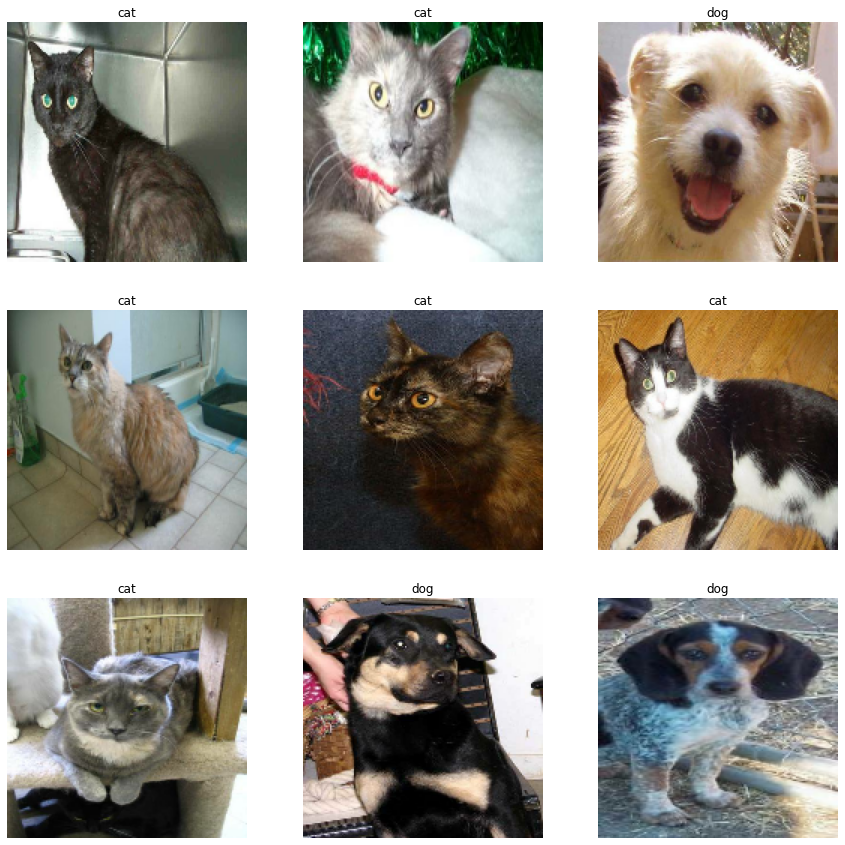

In [13]:
plot_dataset(dataset_train)

<Figure size 432x288 with 0 Axes>

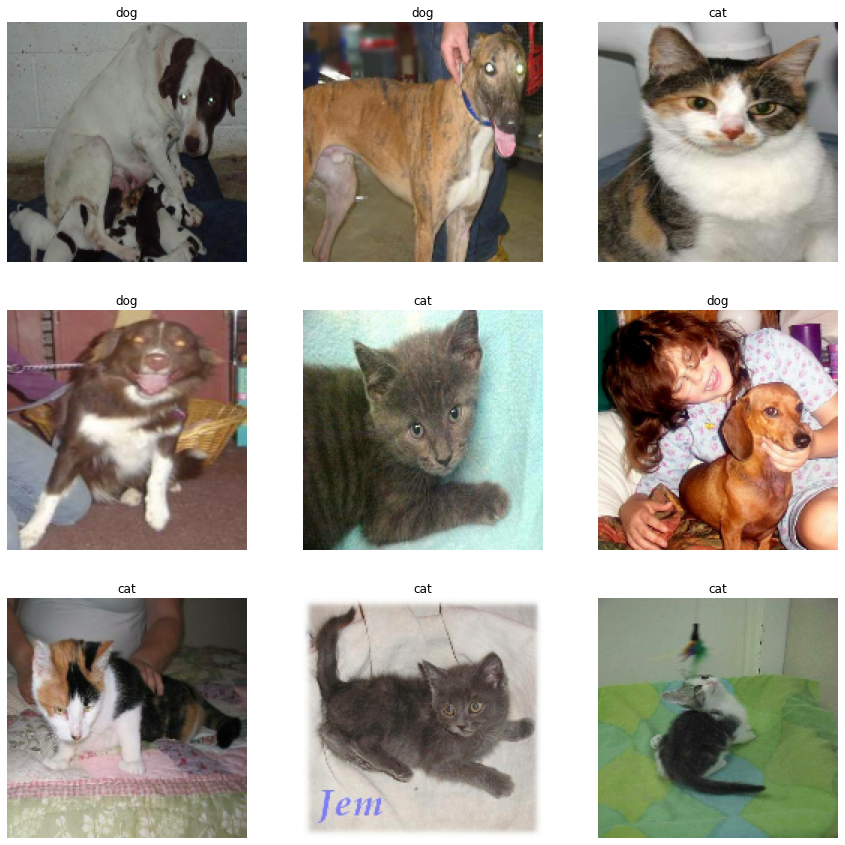

In [14]:
plot_dataset(dataset_validation)

<Figure size 432x288 with 0 Axes>

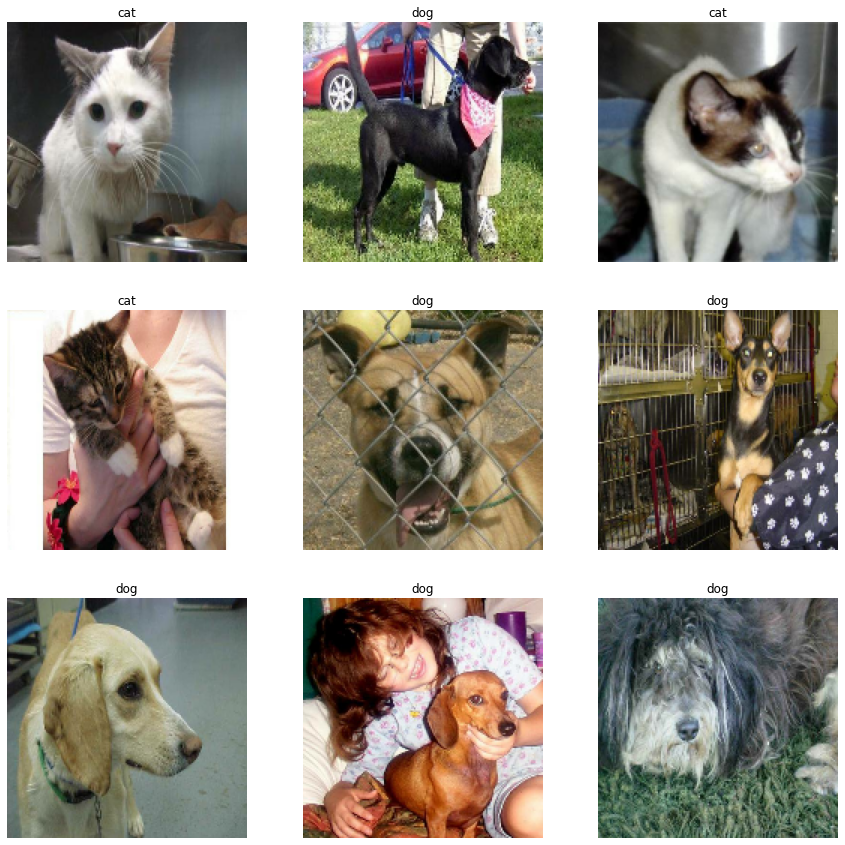

In [15]:
plot_dataset(dataset_test)

## **Aumentando os dados**

In [16]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [17]:
def plot_dataset_data_augmentation(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, _ in dataset.take(1):

        feature = features[0]

        for i in range(9):

            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

<Figure size 432x288 with 0 Axes>

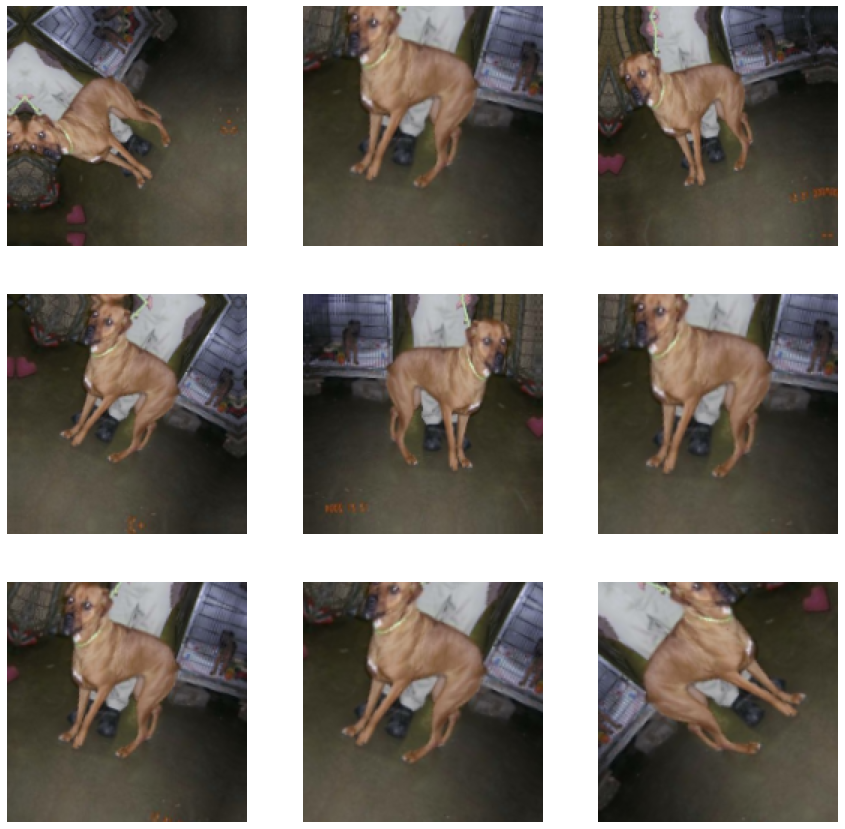

In [18]:
plot_dataset_data_augmentation(dataset_train)

## **Reajuste da camada**

In [19]:
rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1. / (image_color_channel_size / 2.), offset = -1, input_shape = image_shape)

## **Transfer Learning**

In [20]:
model_transfer_learning = tf.keras.applications.MobileNetV2(input_shape = image_shape, include_top = False, weights = 'imagenet')
model_transfer_learning.trainable = False

model_transfer_learning.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

## **Early Stopping**

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

## **Modelo**

In [22]:
model = tf.keras.models.Sequential([
    rescaling,
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                

In [23]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs,
    callbacks = [
        early_stopping
    ]
)

Epoch 1/20
63/63 [==============================] - 63s 934ms/step - loss: 0.6990 - accuracy: 0.6035 - val_loss: 0.5405 - val_accuracy: 0.7438
Epoch 2/20
63/63 [==============================] - 60s 955ms/step - loss: 0.5436 - accuracy: 0.7280 - val_loss: 0.3985 - val_accuracy: 0.8601
Epoch 3/20
63/63 [==============================] - 59s 931ms/step - loss: 0.4076 - accuracy: 0.8280 - val_loss: 0.3166 - val_accuracy: 0.9035
Epoch 4/20
63/63 [==============================] - 59s 941ms/step - loss: 0.3568 - accuracy: 0.8635 - val_loss: 0.2630 - val_accuracy: 0.9295
Epoch 5/20
63/63 [==============================] - 57s 903ms/step - loss: 0.3160 - accuracy: 0.8745 - val_loss: 0.2225 - val_accuracy: 0.9480
Epoch 6/20
63/63 [==============================] - 58s 914ms/step - loss: 0.2862 - accuracy: 0.8905 - val_loss: 0.1976 - val_accuracy: 0.9542
Epoch 7/20
63/63 [==============================] - 59s 934ms/step - loss: 0.2609 - accuracy: 0.9015 - val_loss: 0.1739 - val_accuracy: 0.9592

In [24]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

<Figure size 432x288 with 0 Axes>

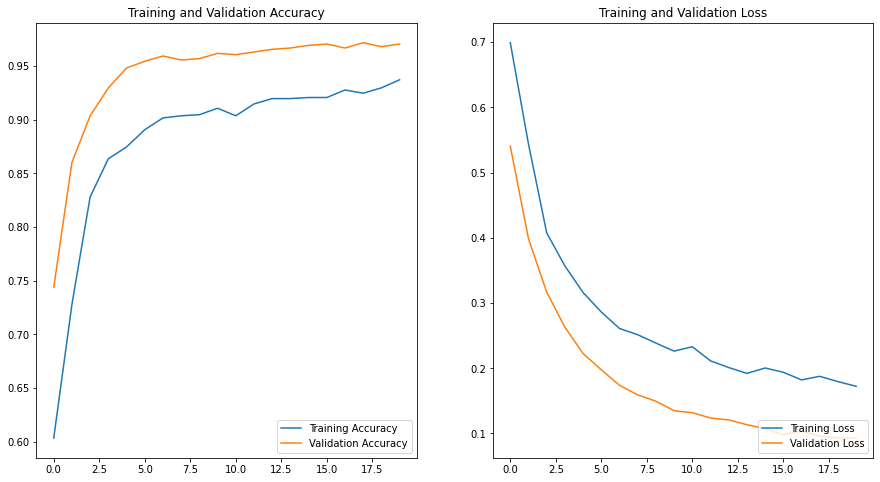

In [25]:
plot_model()

## **Avaliação do Modelo**

In [26]:
dataset_test_loss, dataset_test_accuracy = model.evaluate(dataset_test)

print('Dataset Test Loss:     %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

26/26 [==============================] - 14s 515ms/step - loss: 0.0883 - accuracy: 0.9728
Dataset Test Loss:     0.08831200003623962
Dataset Test Accuracy: 0.9727723002433777


In [27]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels:      [0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1]
Predictions: [0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1]


<Figure size 432x288 with 0 Axes>

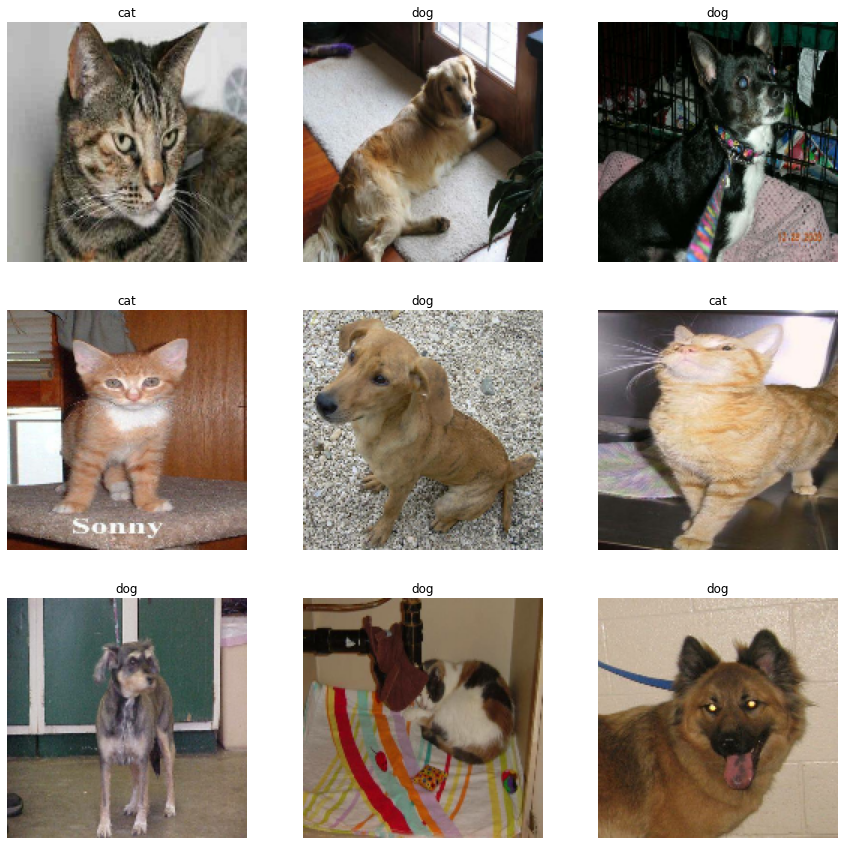

In [29]:
plot_dataset_predictions(dataset_test)

## **Salvando e carregando o modelo**

In [30]:
model.save('model')

In [31]:
model = tf.keras.models.load_model('model')

## **Executando as predições**

In [32]:
def predict(image_file):

    image = tf.keras.preprocessing.image.load_img(image_file, target_size = image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)

    prediction = model.predict(image)[0][0]

    print('Prediction: {0} | {1}'.format(prediction, ('cat' if prediction < 0.5 else 'dog')))

In [33]:
def predict_url(image_fname, image_origin):

    image_file = tf.keras.utils.get_file(image_fname, origin = image_origin)
    return predict(image_file)

In [36]:
predict('teste.jpg')

1/1 [==============================] - 1s 900ms/step
Prediction: 0.9909390807151794 | dog


In [37]:
predict('teste2.jpg')

1/1 [==============================] - 0s 122ms/step
Prediction: 0.002413403242826462 | cat
